This summarizes some options to project Desikan Killiany labels from fsaverage to MNI space, most options should apply to other labels and other spaces with slight adapations. I tried option 1 and 2 and show the outcomes. Option 3 and 4 where suggested to me, but I didn't try them myself.

For most inclusive labelling of gray matter voxels mri_label2vol with the -proj option seems the best solution. But the registration of the surfaces to mni space is problematic in many regions and this solution will also increase the problem of sampling white matter and csf voxels. For more conservative sampling the mri_aparc2aseg solution might be preferable. As compared to the white matter / pial solutions with label2vol (without -proj), arpar2aseg seems to sample more from the center of the gray matter.

Some info is from these links:

https://mail.nmr.mgh.harvard.edu/pipermail//freesurfer/2011-November/021019.html

https://mail.nmr.mgh.harvard.edu/pipermail//freesurfer/2014-January/035524.html

In [1]:
%matplotlib inline

In [2]:
from nilearn import plotting
import matplotlib.pyplot as plt
import nibabel as nb
import numpy as np

In [3]:
data_dir = '/scr/ilz1/label2vol/'

## Option 1: mri_label2vol

Using and .annot or .label file format mri_label2vol can be used to project the labels from surface to volume. The parcellations shipped with Freesurfer in fsaverage space and a registration from fsaverage to MNI152 2mm space are provided with the software. For custom parcellations / labels, one would have to create the respective annot/label file and place it in the fsaverage label folder (or in the label folder of the subject in question and then use the subject's registration and it's T1 as target)

(all commands for right hemisphere, left obviously works respectively, just changing the -hemi parameter)

     export SUBJECT_DIR=$FREESURFER_HOME/subjects

#### Label2vol on pial or white matter surface

    mri_label2vol --subject fsaverage --annot aparc.annot --reg $SUBJECT_DIR/fsaverage/mri/transforms/reg.mni152.2mm.dat --temp $FSLDIR/data/standard/MNI152_T1_2mm_brain.nii.gz --hemi rh --surf pial --o label2vol_rh_pial.nii.gz
    
    mri_label2vol --subject fsaverage --annot aparc.annot --reg $SUBJECT_DIR/fsaverage/mri/transforms/reg.mni152.2mm.dat --temp $FSLDIR/data/standard/MNI152_T1_2mm_brain.nii.gz --hemi rh --surf white --o label2vol_rh_white.nii.gz

#### Label2vol with -proj flag to fill gray matter

The above gives a narrow labelling along the respective surface. If one aims to label the whole gray matter, the -proj flag can be used to propagate the labels from the white matter surface outwards

    mri_label2vol --subject fsaverage --annot aparc.annot --reg $SUBJECT_DIR/fsaverage/mri/transforms/reg.mni152.2mm.dat --temp $FSLDIR/data/standard/MNI152_T1_2mm_brain.nii.gz --hemi rh --surf white --proj frac 0 1 .1 --o label2vol_proj_rh_white.nii.gz

#### Resample to 1mm MNI space e.g. with FSL flirt

    flirt -in label2vol_proj_rh_white.nii.gz -applyisoxfm 1 -interp nearestneighbour -ref $FSLDIR/data/standard/MNI152_T1_1mm_brain.nii.gz -out label2vol_proj_rh_white_1mm.nii.gz 

## Option 2: mri_aparc2aseg

With labels in .annot file format, one can also use mri_aparc2aseg, to project the labels into the space of the automatic segmentation of freesurfer (aseg). Per default the aparc.annot labelling is used. (no ribbon option is equivalent to setting --new-ribbon explicitly, --old-ribbon gives very similar results for the cortex but speckly subcortex)

    mri_aparc2aseg --s fsaverage --o aparc2aseg.nii.gz

#### Resample from MNI305 to MNI152 1mm space

For fsaverage the aseg file is already in MNI305 1mm space, so one just needs to resample the MNI152 1mm (if desired).

    flirt -interp nearestneighbour -nosearch -in aparc2aseg.nii.gz -ref $FSLDIR/data/standard/MNI152_T1_1mm_brain.nii.gz -out aparc2aseg_1mm.nii.gz

##### (Alternative for Desikan-Killiany atlas: the aparc+aseg.mgz volume is already preproduced like described above, altough the results looks slightly differnt)

     mri_convert $SUBJECT_DIR/fsaverage/mri/aparc+aseg.mgz aparc+aseg.nii.gz
   
    flirt -interp nearestneighbour -nosearch -in aparc+aseg.nii.gz -ref $FSLDIR/data/standard/MNI152_T1_1mm_brain.nii.gz -out aparc+aseg_1mm.nii.gz

#### Seperate hemispheres, for visualization only

In [4]:
aparc2aseg_data = nb.load(data_dir + 'aparc2aseg_1mm.nii.gz').get_data()
aparc2aseg_affine = nb.load(data_dir + 'aparc2aseg_1mm.nii.gz').get_affine()
aparc_plus_aseg_data = nb.load(data_dir + 'aparc+aseg_1mm.nii.gz').get_data()
aparc_plus_aseg_affine = nb.load(data_dir + 'aparc+aseg_1mm.nii.gz').get_affine()

In [7]:
aparc2aseg_data[np.where(aparc2aseg_data<500)]=0
aparc2aseg_left = aparc2aseg_data.copy()
aparc2aseg_left[np.where(aparc2aseg_data>1500)]=0
aparc2aseg_nii_left=nb.Nifti1Image(aparc2aseg_left, affine=aparc2aseg_affine)
aparc2aseg_right = aparc2aseg_data.copy()
aparc2aseg_right[np.where(aparc2aseg_data<1500)]=0
aparc2aseg_nii_right=nb.Nifti1Image(aparc2aseg_right, affine=aparc2aseg_affine)
#nb.save(aparc2aseg_nii_left, data_dir + 'aparc2aseg_1mm_left.nii.gz')
#nb.save(aparc2aseg_nii_right, data_dir + 'aparc2aseg_1mm_right.nii.gz')

aparc_plus_aseg_data[np.where(aparc_plus_aseg_data<500)]=0
aparc_plus_aseg_left = aparc_plus_aseg_data.copy()
aparc_plus_aseg_left[np.where(aparc_plus_aseg_data>1500)]=0
aparc_plus_aseg_nii_left=nb.Nifti1Image(aparc_plus_aseg_left, affine=aparc_plus_aseg_affine)
aparc_plus_aseg_right = aparc_plus_aseg_data.copy()
aparc_plus_aseg_right[np.where(aparc_plus_aseg_data<1500)]=0
aparc_plus_aseg_nii_right=nb.Nifti1Image(aparc_plus_aseg_right, affine=aparc_plus_aseg_affine)
#nb.save(aparc_plus_aseg_nii_left, data_dir + 'aparc+aseg_1mm_left.nii.gz')
#nb.save(aparc_plus_aseg_nii_right, data_dir + 'aparc+aseg_1mm_right.nii.gz')

## Compare

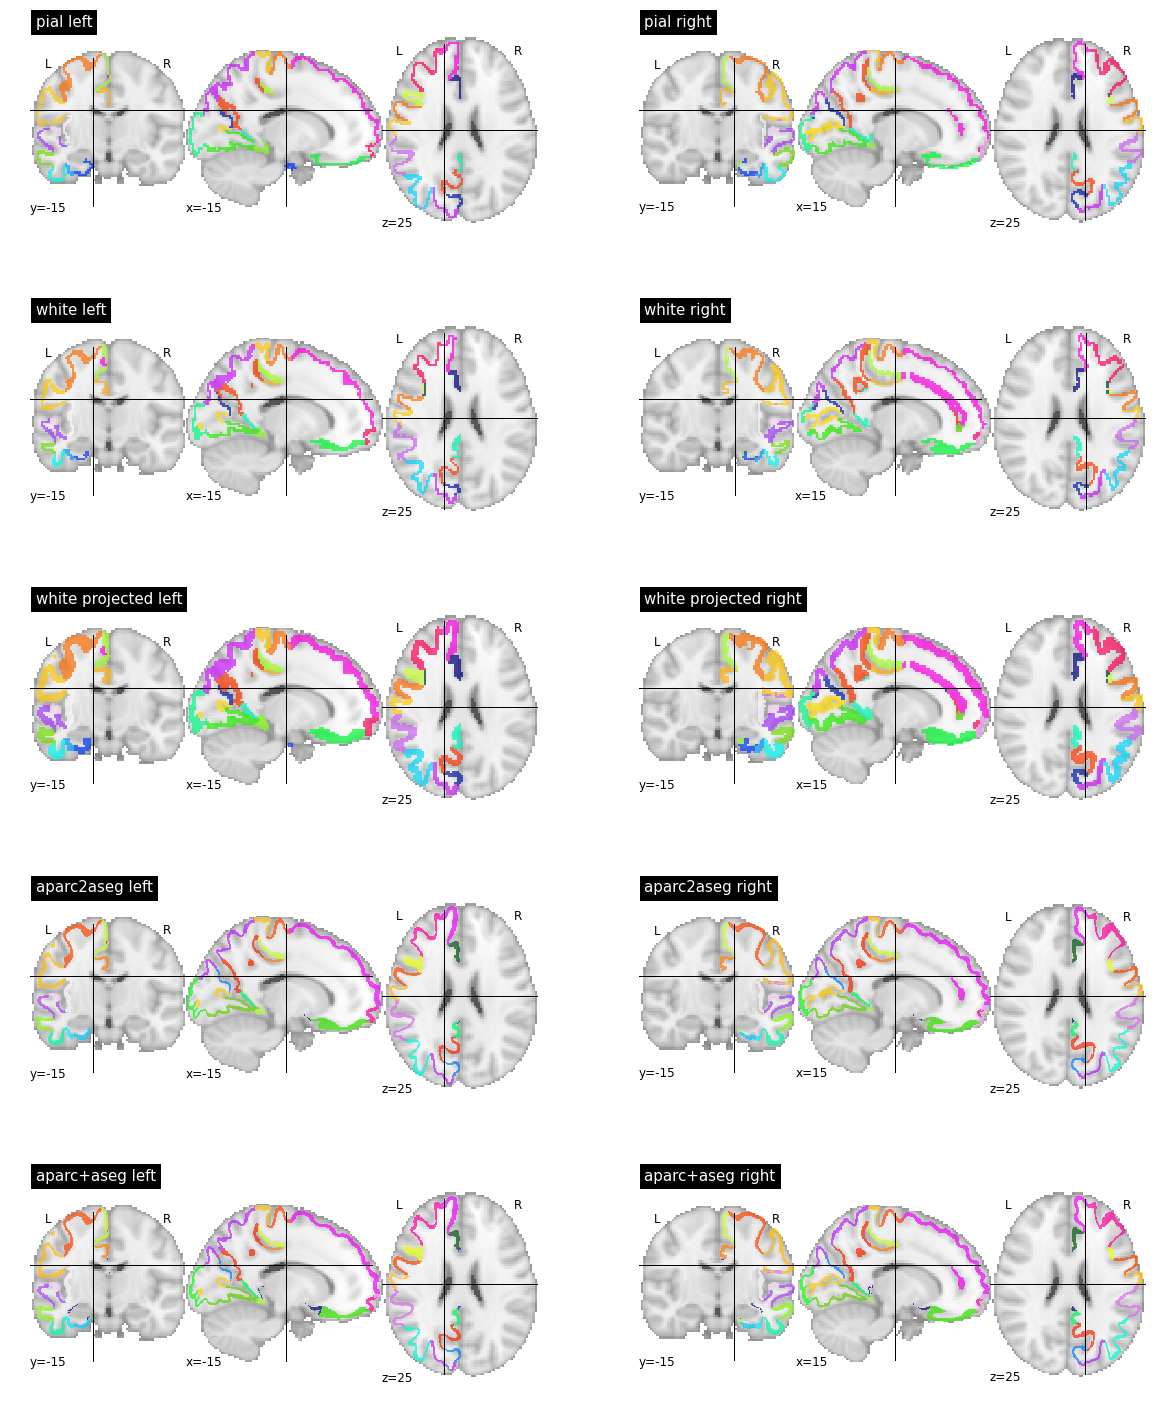

In [8]:
coords_l=(-15, -15, 25)
coords_r=(15, -15, 25)
fig = plt.figure(figsize=(20,25))
ax1=fig.add_subplot(521)
plot=plotting.plot_roi(data_dir + 'label2vol_lh_pial_1mm.nii.gz', cut_coords=coords_l, axes=ax1, title='pial left')
ax2=fig.add_subplot(522)
plot=plotting.plot_roi(data_dir + 'label2vol_rh_pial_1mm.nii.gz',  cut_coords=coords_r, axes=ax2, title='pial right')
ax3=fig.add_subplot(523)
plot=plotting.plot_roi(data_dir + 'label2vol_lh_white_1mm.nii.gz', cut_coords=coords_l, axes=ax3, title='white left')
ax4=fig.add_subplot(524)
plot=plotting.plot_roi(data_dir + 'label2vol_rh_white_1mm.nii.gz',  cut_coords=coords_r, axes=ax4, title='white right')
ax5=fig.add_subplot(525)
plot=plotting.plot_roi(data_dir + 'label2vol_proj_lh_white_1mm.nii.gz',  cut_coords=coords_l, axes=ax5, title='white projected left')
ax6=fig.add_subplot(526)
plot=plotting.plot_roi(data_dir + 'label2vol_proj_rh_white_1mm.nii.gz',  cut_coords=coords_r, axes=ax6, title='white projected right')
ax7=fig.add_subplot(527)
plot=plotting.plot_roi(aparc2aseg_nii_left, cut_coords=coords_l, axes=ax7, title='aparc2aseg left')
ax8=fig.add_subplot(528)
plot=plotting.plot_roi(aparc2aseg_nii_right, cut_coords=coords_r, axes=ax8, title='aparc2aseg right')
ax9=fig.add_subplot(529)
plot=plotting.plot_roi(aparc_plus_aseg_nii_left, cut_coords=coords_l, axes=ax9, title='aparc+aseg left')
ax10=fig.add_subplot(5,2,10)
plot=plotting.plot_roi(aparc_plus_aseg_nii_right, cut_coords=coords_r, axes=ax10, title='aparc+aseg right')

## Option 3: Freesurfer version 6.0.0

There is a new --fill-ribbon option in the mri_label2vol command in the new freesurfer version, which should also do the propagation (instead of -proj)

## Option 4: CARET

    caret_command -file-convert -sc -is GS Q1-Q6_R440.L.midthickness.32k_fs_LR.surf.gii -os CARET fiducialL.coord closedL.topo FIDUCIAL CLOSED -spec fileL.spec -struct LEFT

    caret_command -volume-create-in-stereotaxic-space FNIRT-222 volumeL.313.${i}.nii

    caret_command -surface-to-volume fiducialL.coord closedL.topo hcp.embed.all.313.L.${i}.metric 1 volumeL.313.${i}.nii -inner  -2 -outer 2 -step 0.5